<a href="https://colab.research.google.com/github/str4w/VariousNotebooks/blob/master/TEST_RL_Games_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some musings on reinforcement learning for games.



Preliminaries
---------------

In [ ]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {    return false;   }

<IPython.core.display.Javascript object>

In [ ]:
import gym
import gym.spaces
import numpy as np
import matplotlib.pyplot as plt;

%matplotlib inline
fig_size_inline = (13, 9)
plt.rcParams["figure.figsize"] = fig_size_inline

Introduction
------------
Some toying around with Q Learning on the taxi game\*.



The taxi game takes place on a 5x5 grid.  The layout of the grid is fixed.  There are four special locations on that grid, a passenger needs to be picked up from one, and taken to another.  Thus the state space for this game is relatively small - the taxi's location is 5x5, the passenger can be in one of 5 locations (the four special locations, and the taxi itself), and the destination can be one of four locations.

There are 6 actions - movement in the cardinal directions, pickup and dropoff.

Reward is -1 per step.



It is a nice environment because it is tiny and simple.  However, there is no opponent - so it is just a puzzle of sorts, not a true game (mathematically speaking).

\*The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

The environment is simply represented as text, which the environment.render call produces. 

    rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters: locations

In [ ]:
env = gym.make('Taxi-v2')
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



/storage2/rupert/src/openai/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


Lets try Q-Learning, roughly as suggested in the following article, pretty much as out of the box.  This sets up basic Q-Learning, which makes an estimates reward for each action for each possible state.  It runs 1000 training episodes, printing every 100th game.  

The reward per episode is graphed at the end.

https://www.oreilly.com/learning/introduction-to-reinforcement-learning-and-openai-gym

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 100 Total Reward: -80
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 200 Total Reward: 11
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 300 Total Reward: 9
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 400 Total Reward: 4
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 500 Total Reward: 7
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 600 Total Reward: 3
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 700 Total Reward: 13
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 800 Total Reward: 10
+--

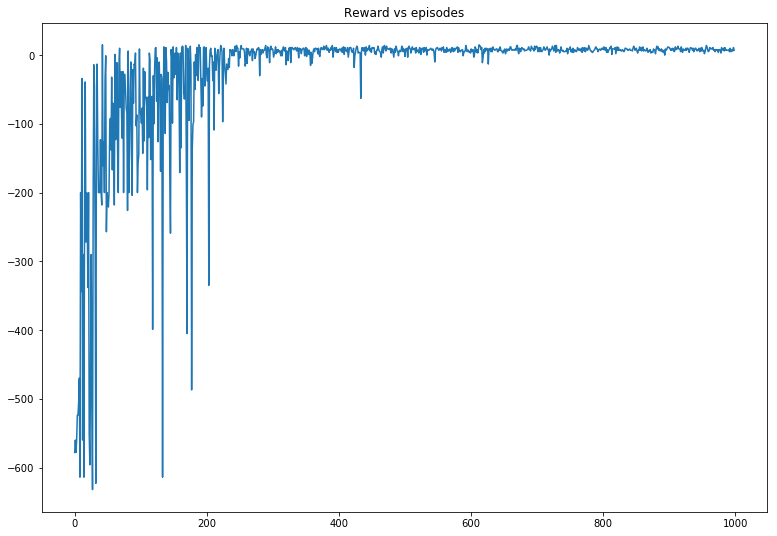

In [ ]:
rewards=[]
Q=np.zeros((env.observation_space.n,env.action_space.n))
G=0
alpha=0.618

# make a somewhat more sophisticated action selector, will be useful later
def argmax_not_nan(values):
    bestindex=None
    bestvalue=np.nan
    for i,r in enumerate(values):
        if not np.isnan(r) and (np.isnan(bestvalue) or r>bestvalue):
            bestindex=i
            bestvalue=r
    if bestindex is None:
        print("Error in argmax not nan")
        print("values",values)
    return bestindex
def select_action(reward):
    return argmax_not_nan(reward)

for episode in range(1,1000):
    done = False
    G, reward = 0,0
    state = env.reset()
    while done != True:
            action = select_action(Q[state]) #1
            state2, reward, done, info = env.step(action) #2
            Q[state,action] += alpha * (reward + np.max(Q[state2]) - Q[state,action]) #3
            Counts[state,action] +=1
            G += reward
            state = state2   
    rewards.append(G)
    if episode % 100 == 0:
        env.render()
        print('Episode {} Total Reward: {}'.format(episode,G))
print("Finished training")
plt.plot(rewards)
plt.title("Reward vs episodes")
plt.show()

We see that in the beginning, it is basically crap, as expected, but it seems to come to some kind of stable solution after about 500 episodes.  Let's try to look under the hood to see what it is learning.  The way the environment is actually coded in the implementation doesn't map easily to an intuitive breakdown of the states of the game and the strategies for them.  We can do better, however.  Consider that 
- the game naturally divides into two parts - when the taxi is empty, and when there is a passenger in the taxi.  (Worded this way because you actually can drop the passenger at the wrong place and need to pick them up again.)
- When the taxi is empty, we ought to be going to pick up the passenger. In this case the destination is nearly irrelevant, but the information for how to pick up the passenger is stored separately (and has to be learned separately) for each destination anyway.
- The destination is fixed for each episode, and once the passenger is picked up, we should head to that location.
So for each of the four possible pickup positions we can show the actions for each square, and for each of the four dropoff positions we can show the actions for each square.

In the following, will try to illustrate this graphically.

In [ ]:
# we will change up a few things

# - reorder the variables in the state space to be more intutively meaningful
# - keep a count of the number of times a state has been visited

rewards=[]
Q=np.zeros((env.observation_space.n,env.action_space.n))
Counts=np.zeros((env.observation_space.n,env.action_space.n))
G=0
alpha=0.618
def newencode(taxirow,taxicol,passenger,destination):
    val=destination
    val*=5
    val+=passenger
    val*=5
    val+=taxicol
    val*=5
    val+=taxirow
    return val
def newdecode(val):
    taxirow=val%5
    val/=5
    taxicol=val%5
    val/=5
    passenger=val%5
    val/=5
    destination=val
    return taxirow,taxicol,passenger,destination
def reencode(val):
    tr,tc,p,d=env.env.decode(val)
    return newencode(tr,tc,p,d)

def drawQAndCounts():
    ax=plt.subplot(1,2,1)
    ax.imshow(Q,aspect="auto")
    plt.title("Q")
    ax=plt.subplot(1,2,2)
    ax.imshow(Counts,aspect="auto")
    plt.show()

sites=["R","G","Y","B"]
def drawTaxiGrid():
    plt.axis("equal")
    plt.xlim([-0.5,5.5])
    plt.ylim([-0.5,5.5])
    plt.xticks([])
    plt.yticks([])
    for i in range(1,5):
        plt.plot([0,5],[i,i],'k:')
        plt.plot([i,i],[0,5],'k:')
    for i in [0,5]:
        plt.plot([0,5],[i,i],'k-')
        plt.plot([i,i],[0,5],'k-')
    plt.plot([1,1],[0,2],'k-')
    plt.plot([3,3],[0,2],'k-')
    plt.plot([2,2],[4,5],'k-')
    plt.text(0.5,0.5,'Y',horizontalalignment='center', verticalalignment='center',fontsize=12)
    plt.text(0.5,4.5,'R',horizontalalignment='center', verticalalignment='center',fontsize=12)
    plt.text(3.5,0.5,'B',horizontalalignment='center', verticalalignment='center',fontsize=12)
    plt.text(4.5,4.5,'G',horizontalalignment='center', verticalalignment='center',fontsize=12)
    
def drawActions(ps,ds):
    #note, the vertical axis is reversed in the plot, 
    for tr in range(5):
        for tc in range(5):
            cx=tc+0.5
            cy=(4-tr)+0.5
            actionGuides=np.nan*np.zeros(6)
            for p in ps:
                for d in ds:
                    state=newencode(tr,tc,p,d)
                    qactions=Q[state,:]
                    for i in range(len(actionGuides)):
                        if np.isnan(actionGuides[i]):
                            actionGuides[i]=qactions[i]
                        elif not np.isnan(qactions[i]):
                            actionGuides[i]+=qactions[i]
            minidx=argmax_not_nan(-1.0*actionGuides)
            actionGuides-=actionGuides[minidx]
            m=actionGuides[argmax_not_nan(actionGuides)]
            if m > 0:
                actionGuides/=m
                actionGuides/=2. # we want to extend to a radius of 0.5, not 1
            else:
                actionGuides+=0.5 # everything is equally possible
            plt.plot([cx,cx],[cy,cy-actionGuides[0]],'r-')  # up / down reversed because of coord system
            plt.plot([cx,cx],[cy,cy+actionGuides[1]],'r-')
            plt.plot([cx,cx+actionGuides[2]],[cy,cy],'r-')
            plt.plot([cx,cx-actionGuides[3]],[cy,cy],'r-')
            plt.gca().add_artist(plt.Circle((cx,cy),actionGuides[4],edgecolor='b',fill=False))
            plt.plot([cx-actionGuides[5],cx+actionGuides[5]],[cy-actionGuides[5],cy+actionGuides[5]],'b-')
            plt.plot([cx+actionGuides[5],cx-actionGuides[5]],[cy-actionGuides[5],cy+actionGuides[5]],'b-')
    
    
def drawLearnedStrategy():
    for p in range(4):
        plt.subplot(2,4,p+1)
        drawTaxiGrid()
        drawActions([p,],[0,1,2,3])
        plt.title("Passenger @ %s"%(sites[p]))
    for d in range(4):
        plt.subplot(2,4,d+5)
        drawTaxiGrid()
        drawActions([4,],[d,])
        plt.title("Destination @ %s"%(sites[d]))
    plt.show()
    
def train():    
    for episode in range(1001):
        done = False
        G, reward = 0,0
        state = env.reset()
        state = reencode(state)
        while done != True:
            action = select_action(Q[state]) #1
            state2, reward, done, info = env.step(action) #2
            state2 = reencode(state2)
            Q[state,action] += alpha * (reward + Q[state2,argmax_not_nan(Q[state2])] - Q[state,action]) #3
            Counts[state,action] +=1
            G += reward
            state = state2   
        rewards.append(G)
        if episode % 100 == 0:
            env.render()
            print('Episode {} Total Reward: {}'.format(episode,G))
            drawQAndCounts()
            drawLearnedStrategy()
    print("Finished training")



So in the following illustrations, the strategy (the Q matrix) is represented for each situation (passenger position and destination), as red lines indicating the preferred directions, and a blue circle for pickup, and a blue x for dropoff.  The size of the symbols represents preference.

The strategy before training


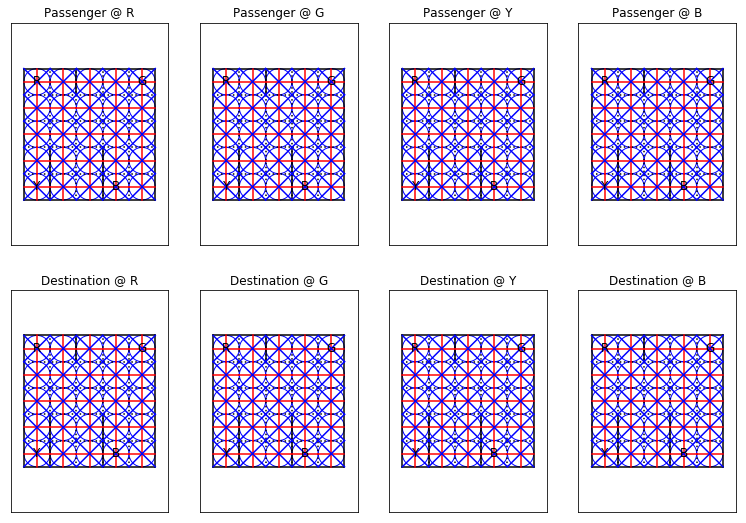

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Episode 0 Total Reward: -560


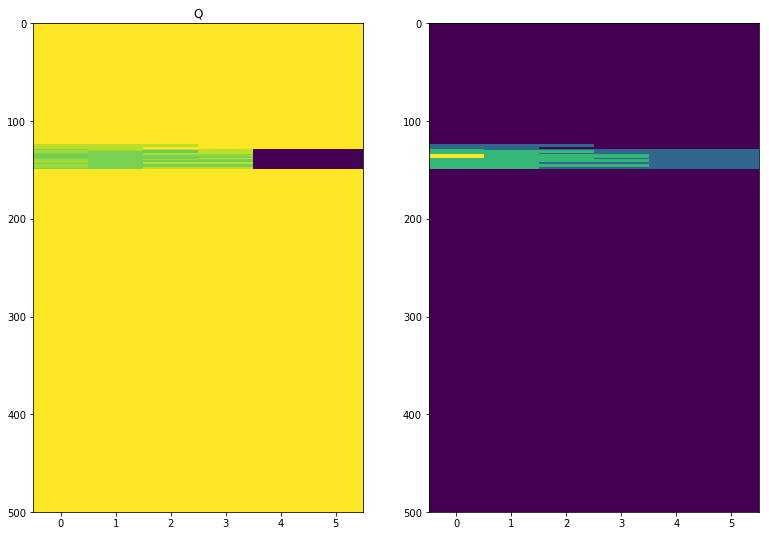

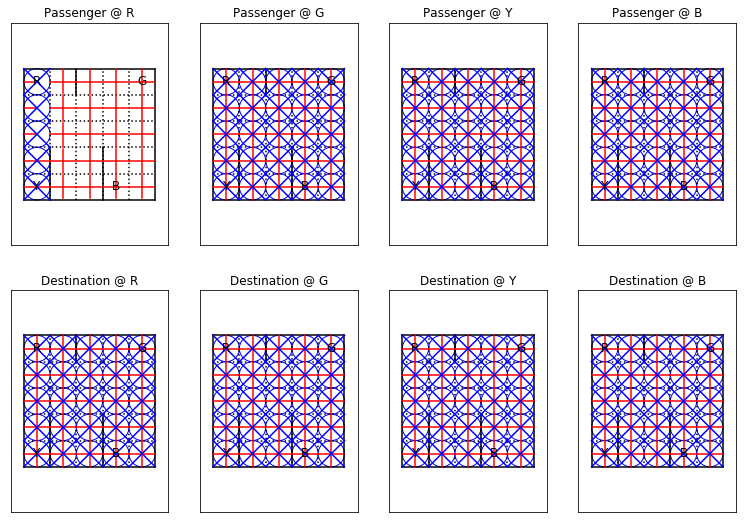

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 100 Total Reward: -19


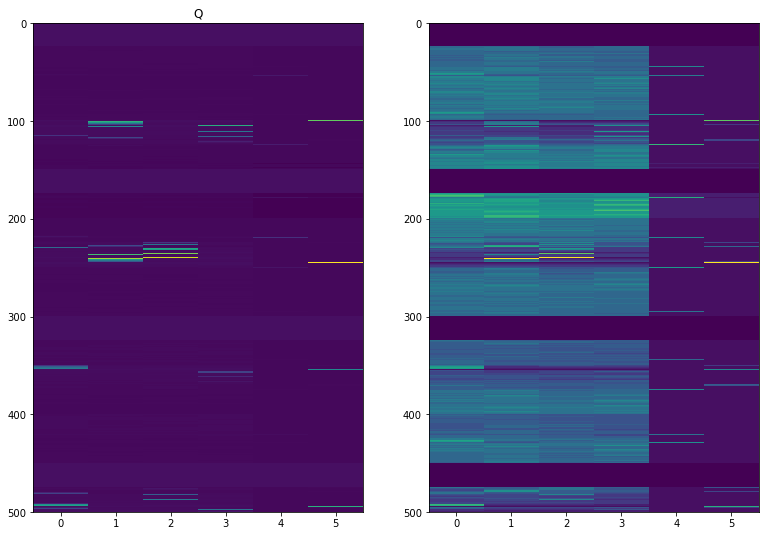

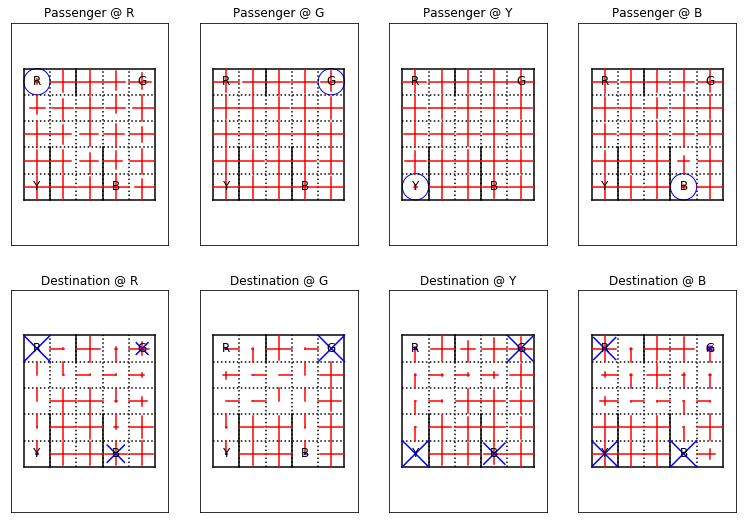

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 200 Total Reward: 9


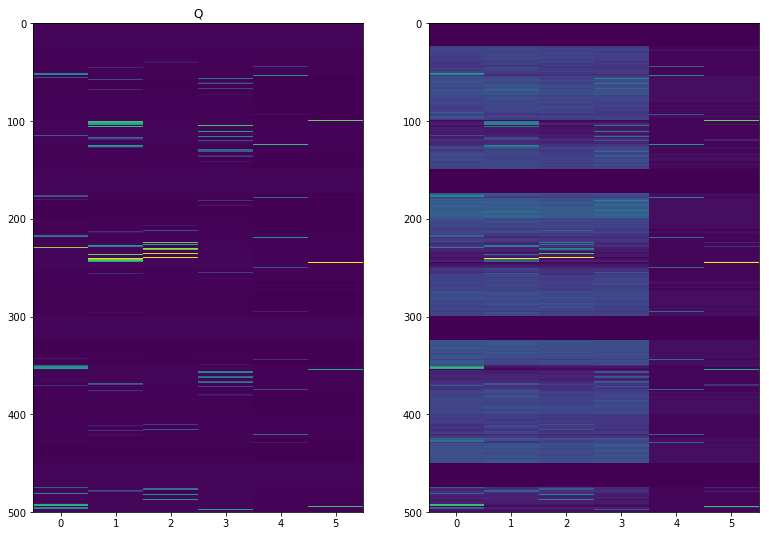

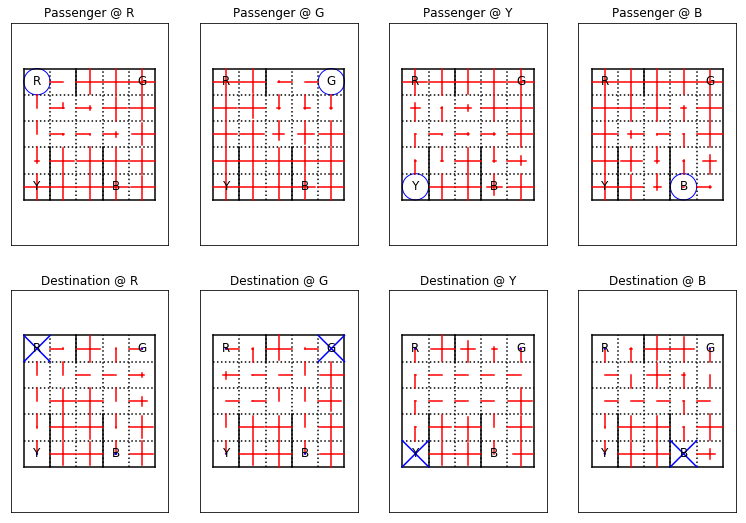

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 300 Total Reward: -1


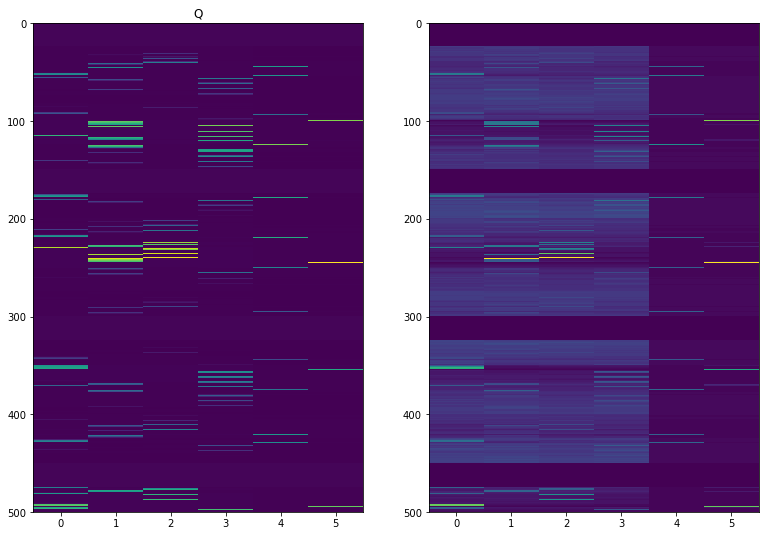

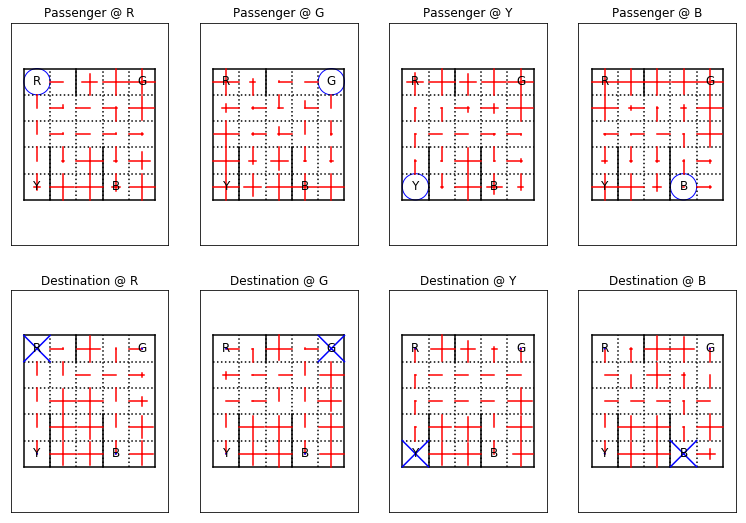

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 400 Total Reward: 12


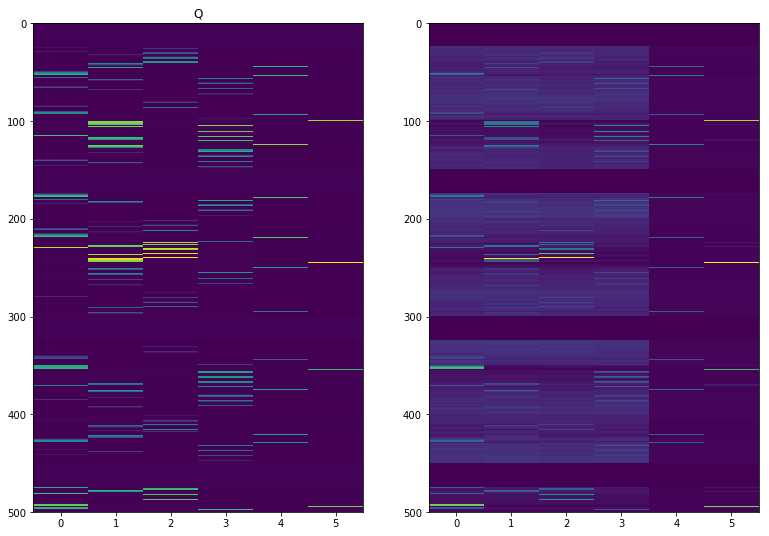

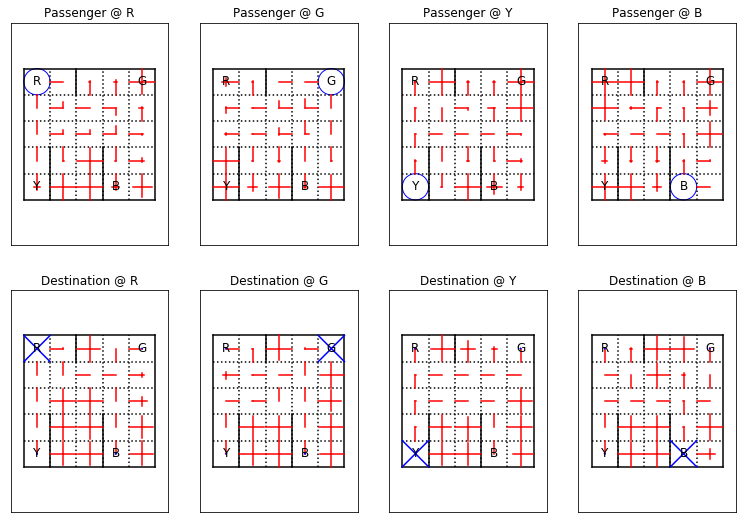

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 500 Total Reward: 4


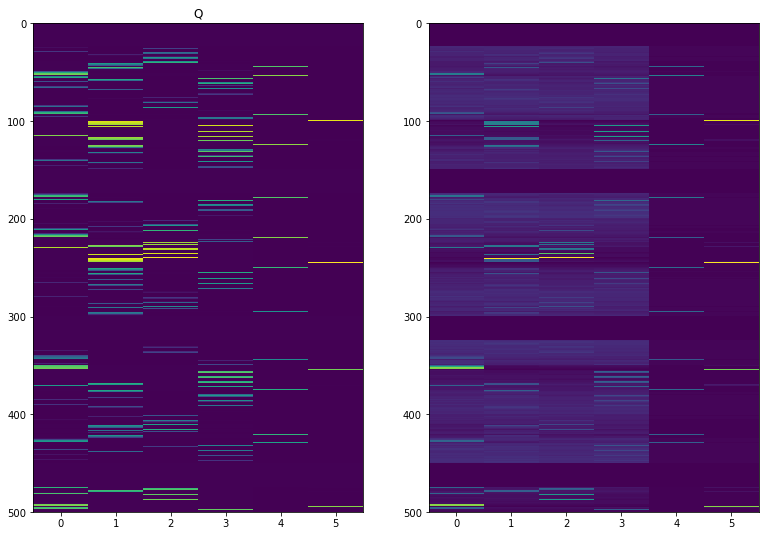

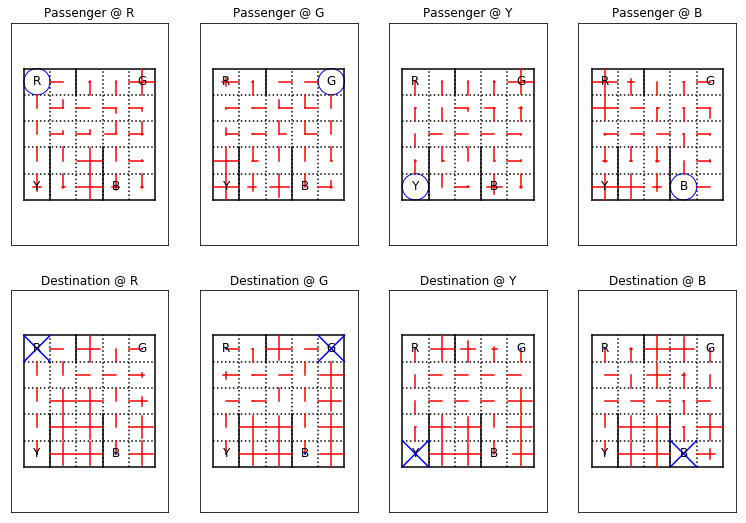

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 600 Total Reward: 11


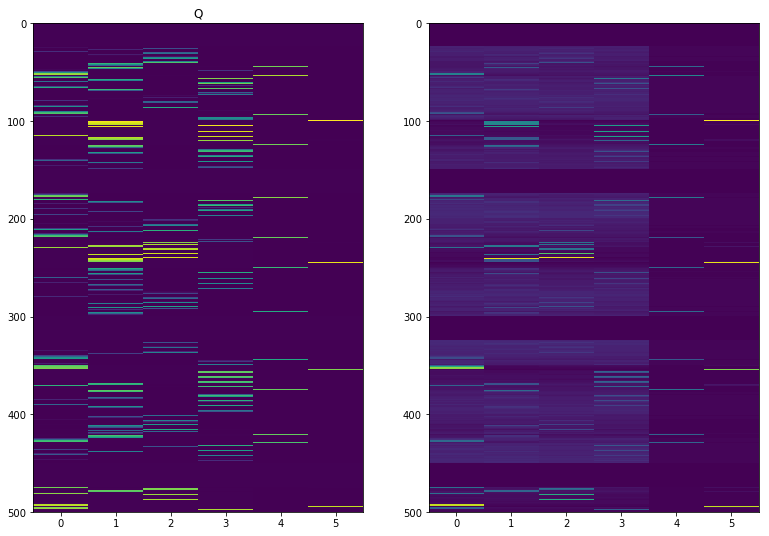

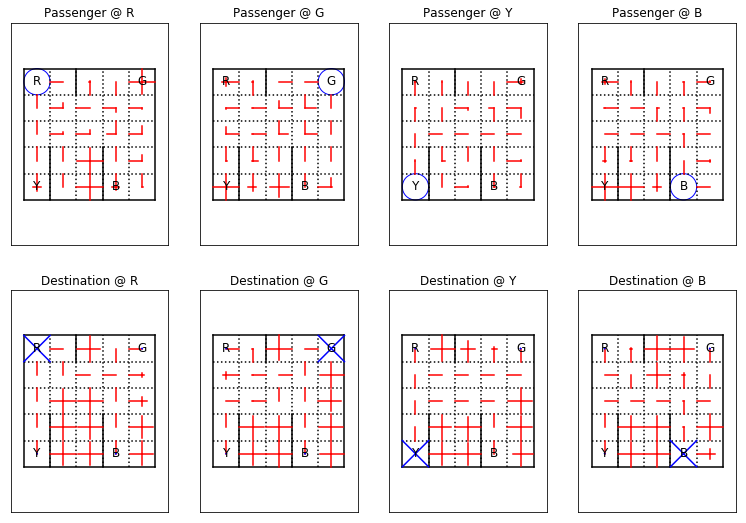

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 700 Total Reward: 8


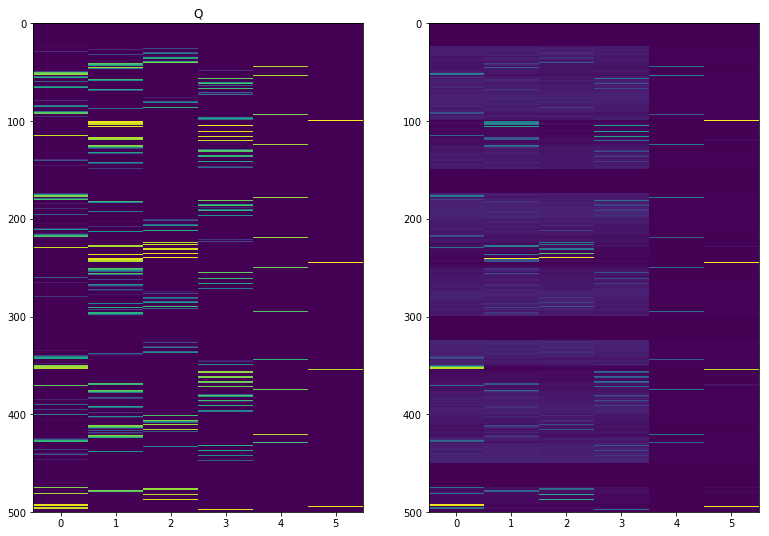

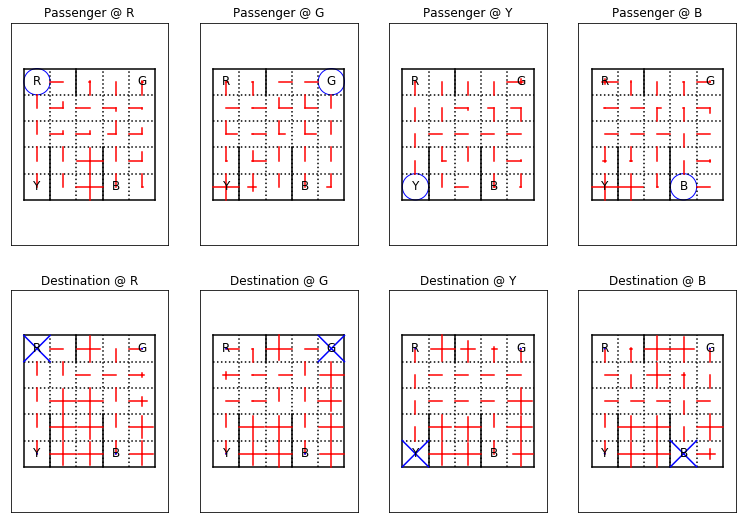

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 800 Total Reward: 3


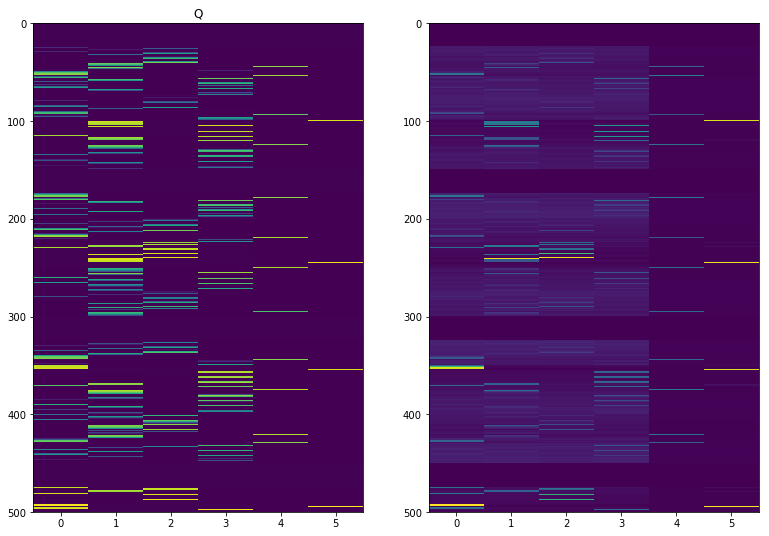

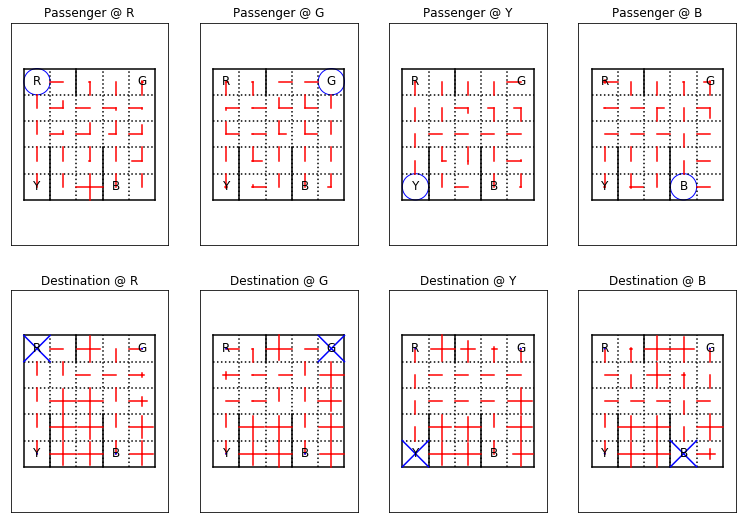

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 900 Total Reward: 6


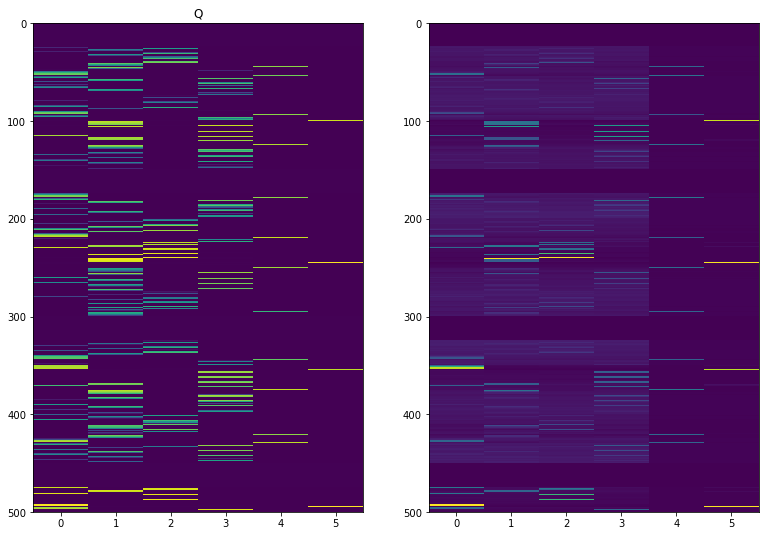

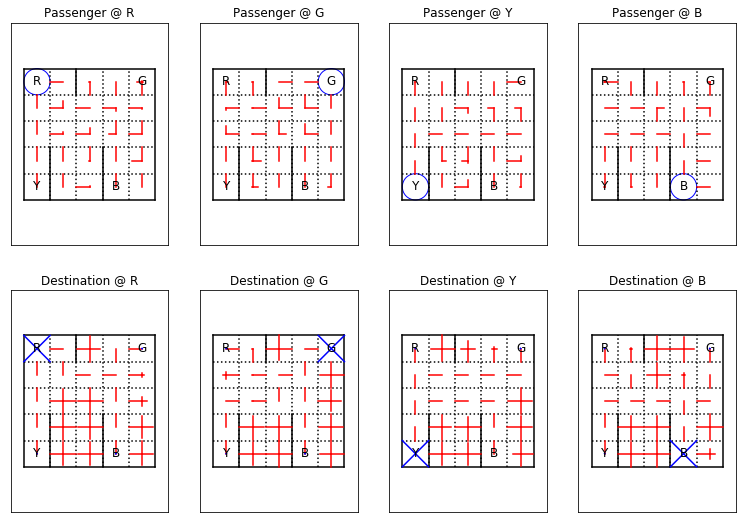

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 1000 Total Reward: 8


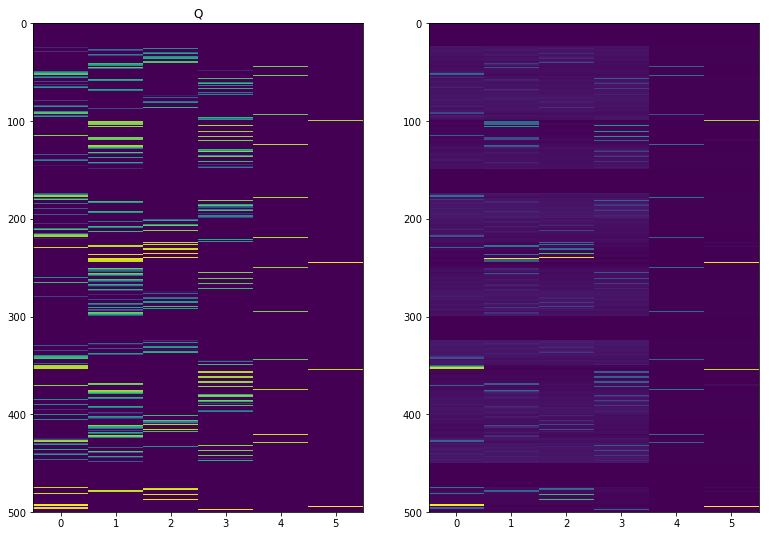

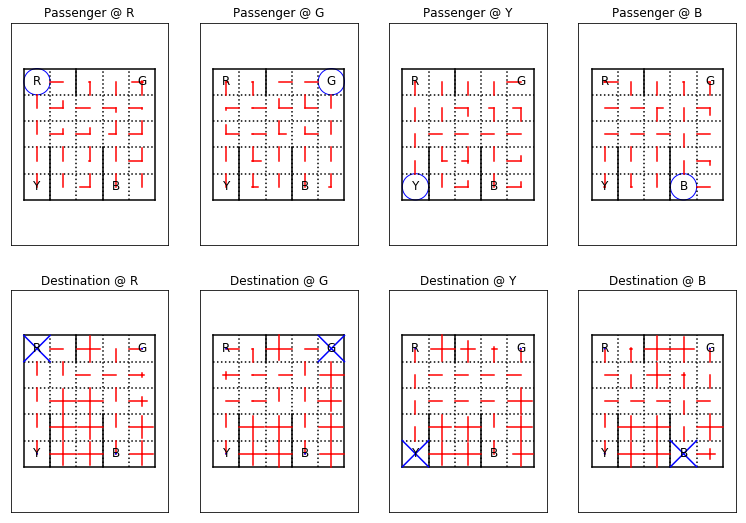

Finished training


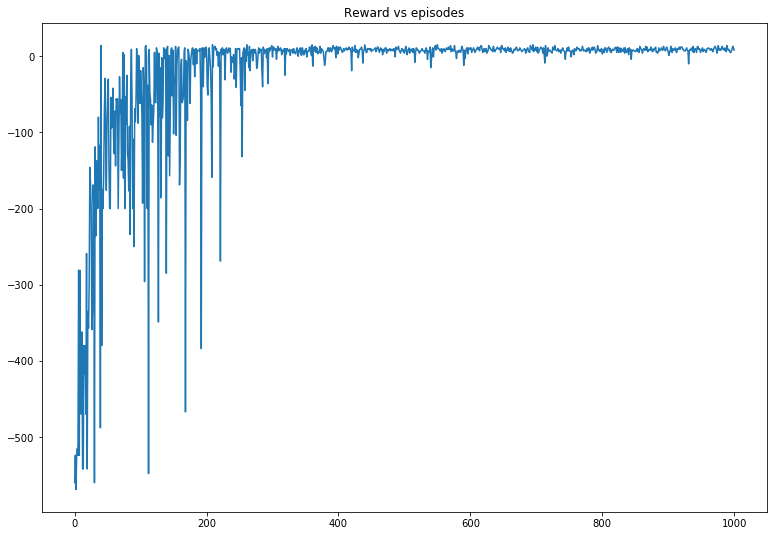

In [ ]:
print("The strategy before training")    
drawLearnedStrategy()
    
train()
plt.plot(rewards)
plt.title("Reward vs episodes")
plt.show()

Here we see the strategy take shape as the number of episodes increases.  Note in the count graphs how certain things never happen - the passenger is never located at their destination for example.  Also, certain parts of the strategy never get developed - the system never learns not to go through some walls on its way to the destination, because it never needs to go near that wall.

Now - could we accelerate learning by giving Q-Learning a little help.  There are certain actions that are generally poor, and we may be able to speed things along by eliminating them from the options right away. Examples
- trying to make an impossible move
- pickup and dropoff at in appropriate times.

We could also possibly combine states that are equivalent (or nearly equivalent).  The destination only very weakly affects the pickup point strategy.

In the following, the first two rule are applied and parts of the strategy are precomputed.

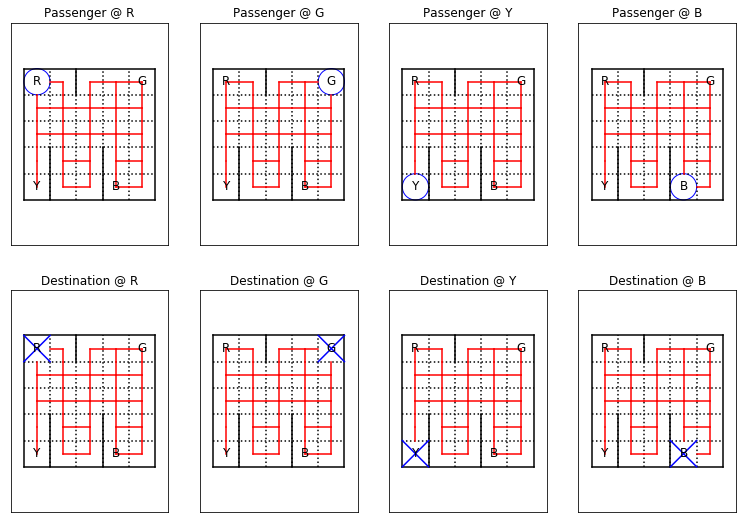

In [ ]:
Q=np.zeros((env.observation_space.n,env.action_space.n))
Counts=np.zeros((env.observation_space.n,env.action_space.n))
G=0
alpha=0.618

neverValue=np.nan
alwaysValue=1.e20

# Eliminate impossible moves
for p in range(5):
    for d in range(4):
        for tr in range(5):
            state=newencode(tr,0,p,d)
            Q[state,3]=neverValue  # cant go left at left edge
            state=newencode(tr,4,p,d)
            Q[state,2]=neverValue  # cant go right at right edge
        for tc in range(5):
            state=newencode(0,tc,p,d)
            Q[state,1]=neverValue  # cant go up at top edge
            state=newencode(4,tc,p,d)
            Q[state,0]=neverValue  # cant go down at bottom edge
        # cant pass through walls
        state=newencode(0,2,p,d)
        Q[state,3]=neverValue  
        state=newencode(0,1,p,d)
        Q[state,2]=neverValue 
        # cant pass through walls
        for tr in [3,4]: 
            state=newencode(tr,1,p,d)
            Q[state,3]=neverValue  
            state=newencode(tr,0,p,d)
            Q[state,2]=neverValue 
            state=newencode(tr,3,p,d)
            Q[state,3]=neverValue  
            state=newencode(tr,2,p,d)
            Q[state,2]=neverValue 

# Only drop off if passenger is in the car, and we are at destination
# but then, that is the only valid action
Q[:,5]=neverValue
for tr,tc,p,d in [(0,0,4,0),(0,4,4,1),(4,0,4,2),(4,3,4,3)]:
    state=newencode(tr,tc,p,d)
    Q[state,:]=neverValue  
    Q[state,5]=alwaysValue
# Only pick up we are same location as passenger
# but then, that is the only valid action
Q[:,4]=neverValue
for tr,tc,p in [(0,0,0),(0,4,1),(4,0,2),(4,3,3)]:
    for d in range(4):
        state=newencode(tr,tc,p,d)
        Q[state,:]=neverValue  
        Q[state,4]=alwaysValue



drawLearnedStrategy()

Note how the initial strategy makes much more sense, with impossible actions removed, and in appropriate dropoff and pickup forbidden.

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 0 Total Reward: -24


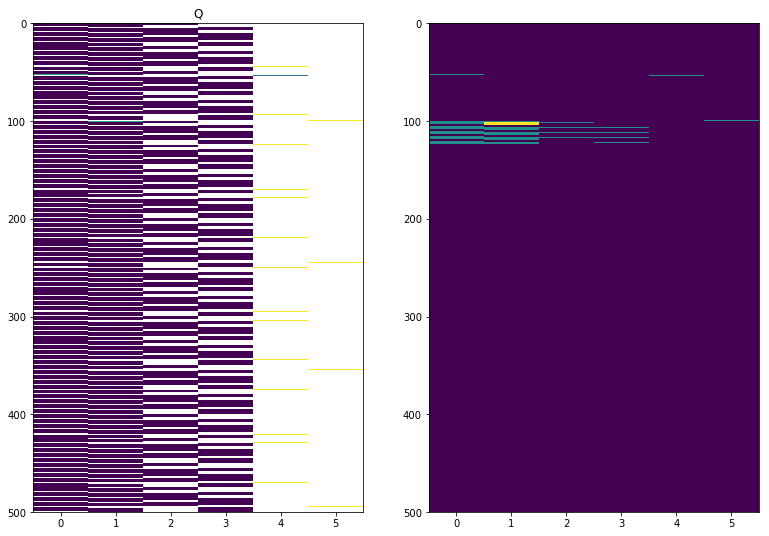

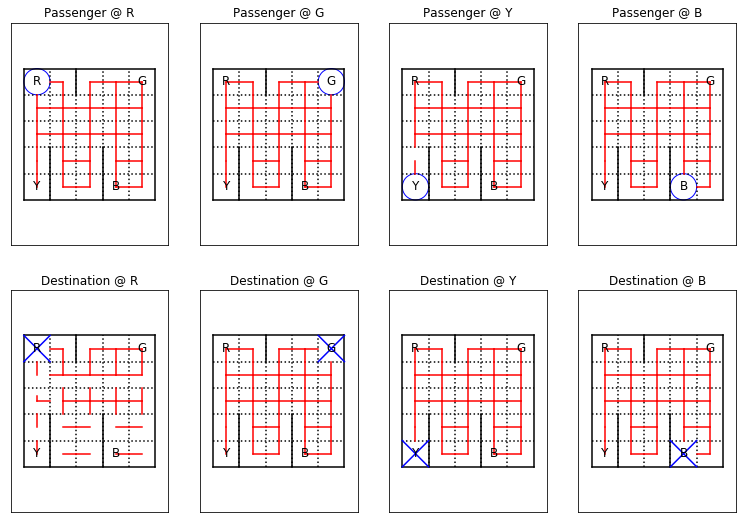

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 100 Total Reward: 9


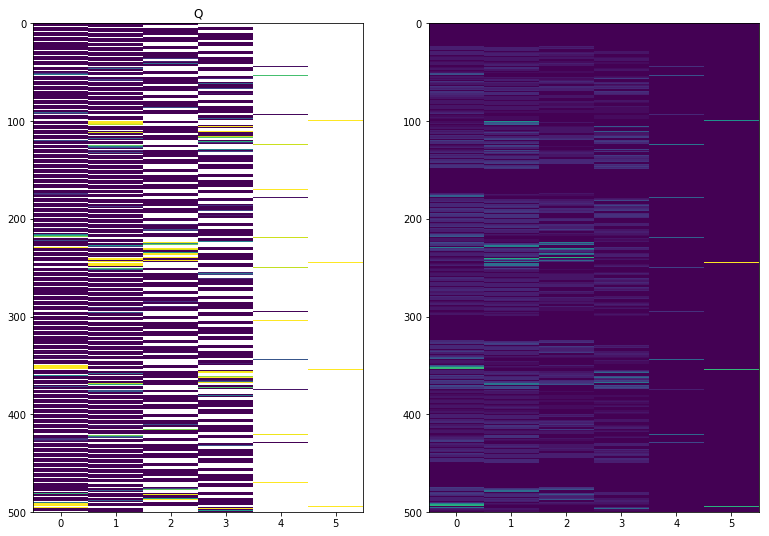

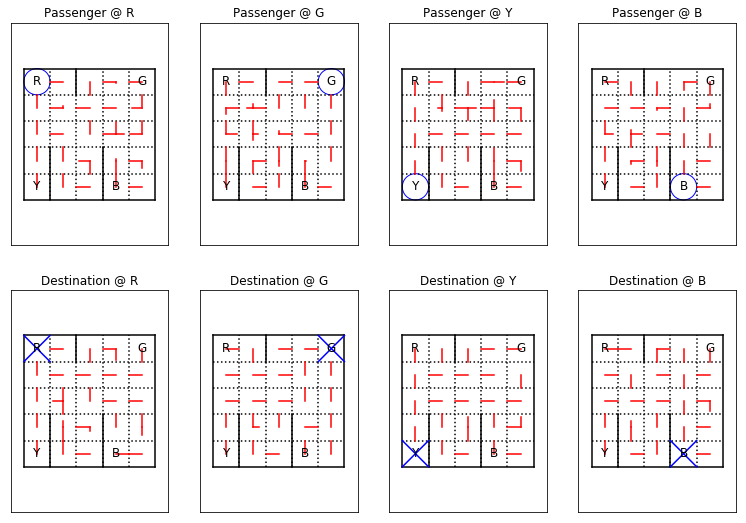

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 200 Total Reward: 6


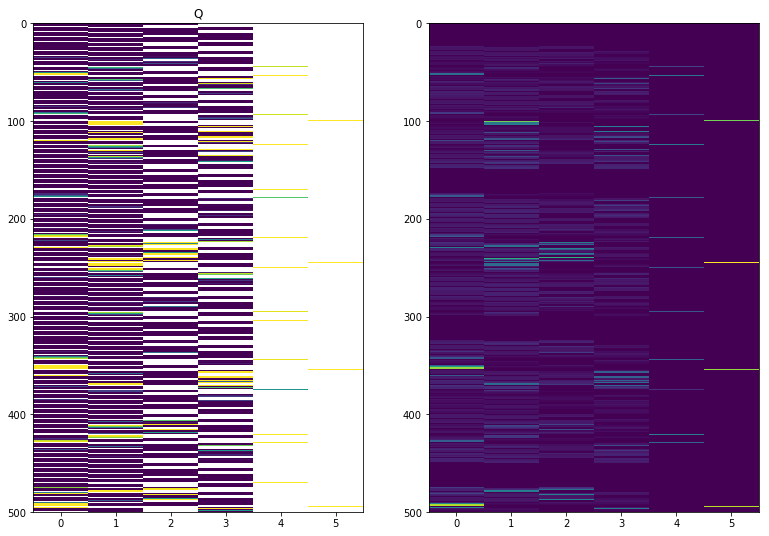

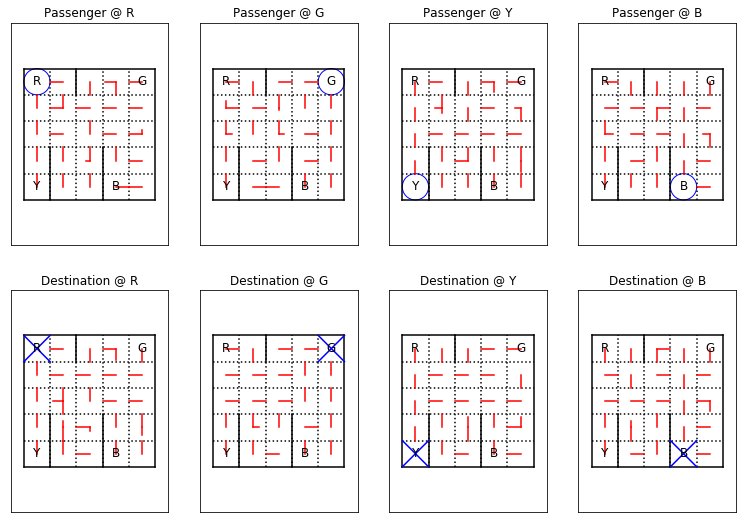

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 300 Total Reward: 6


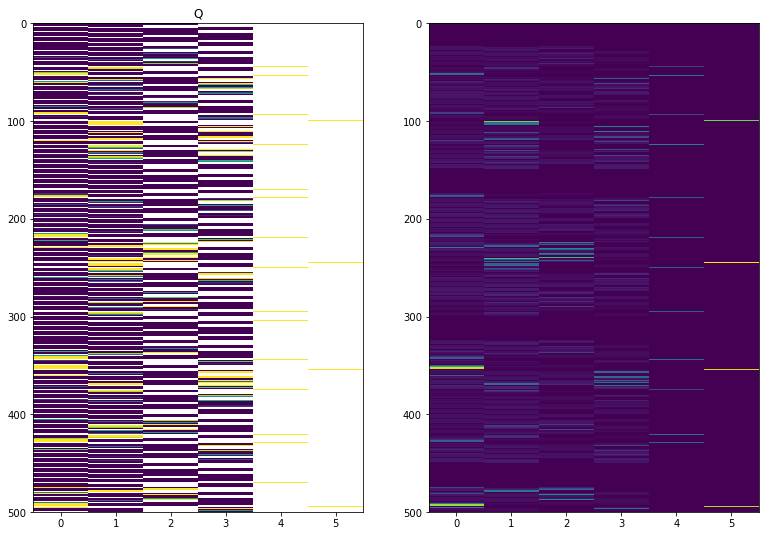

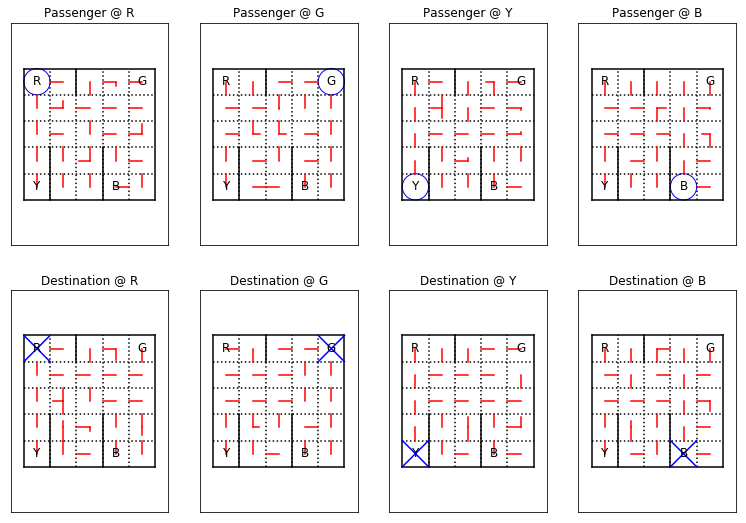

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 400 Total Reward: 12


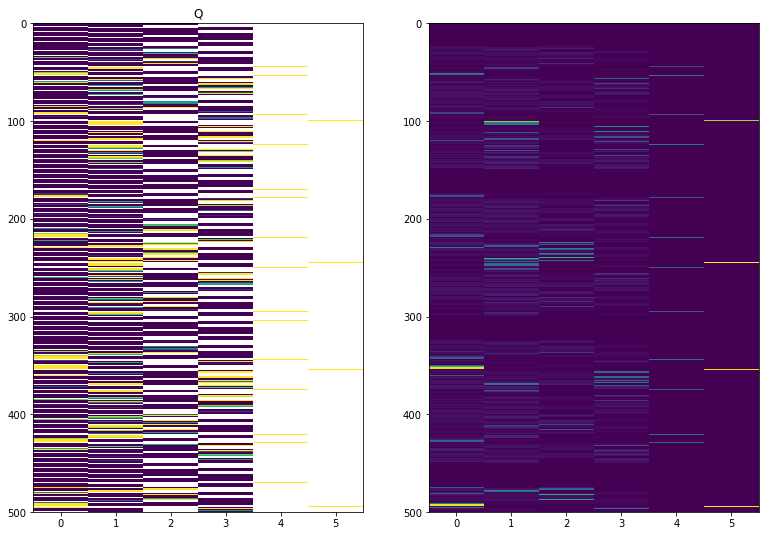

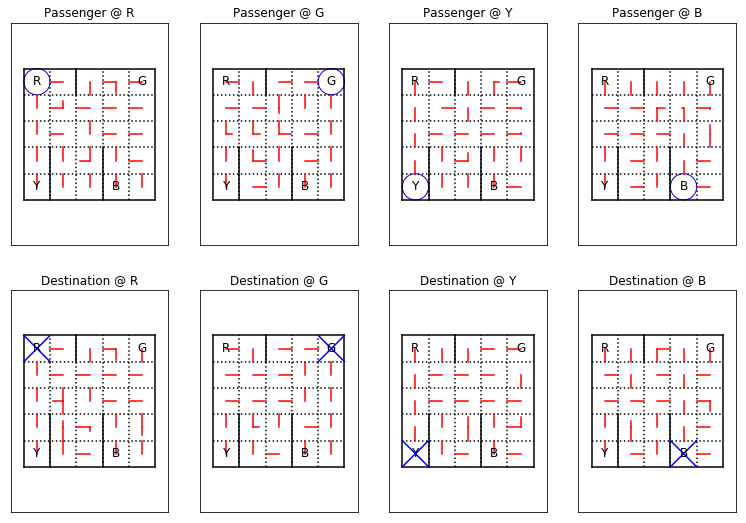

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 500 Total Reward: 4


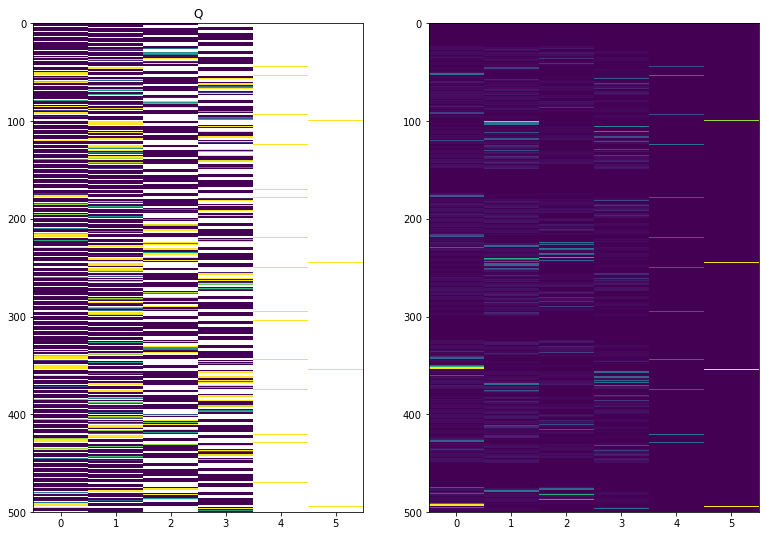

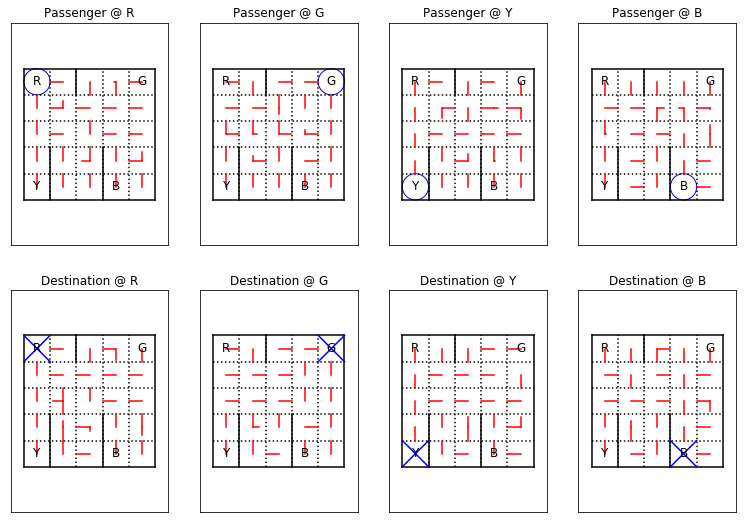

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 600 Total Reward: 8


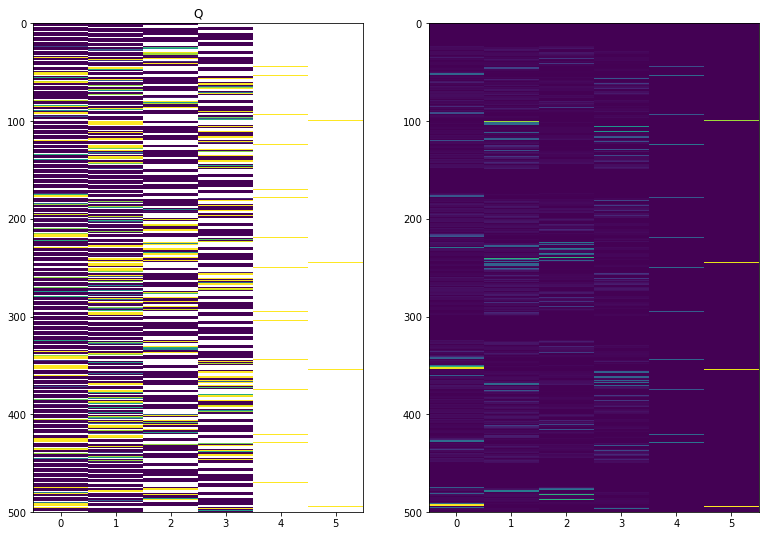

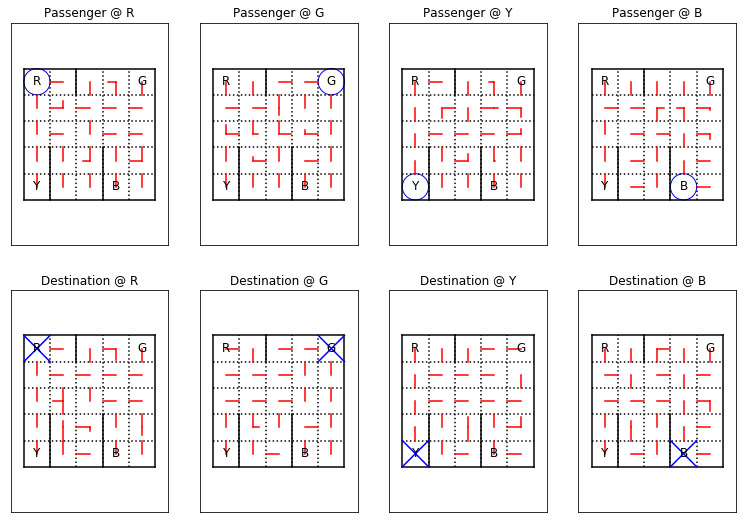

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 700 Total Reward: 8


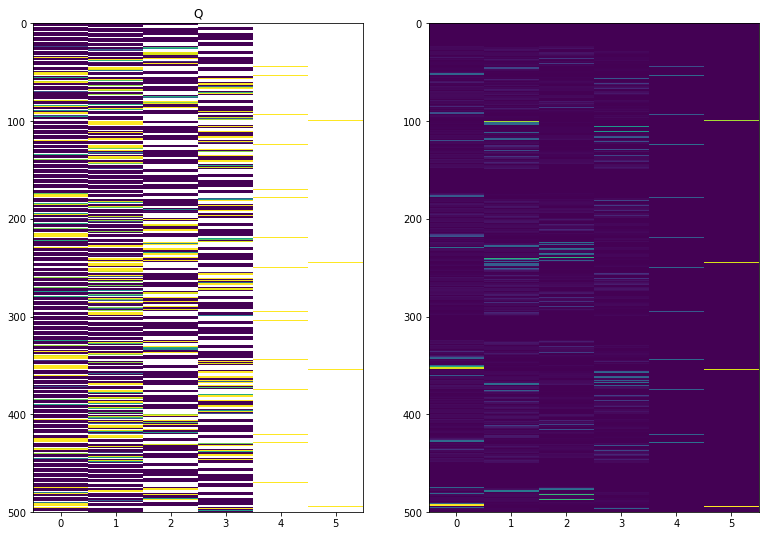

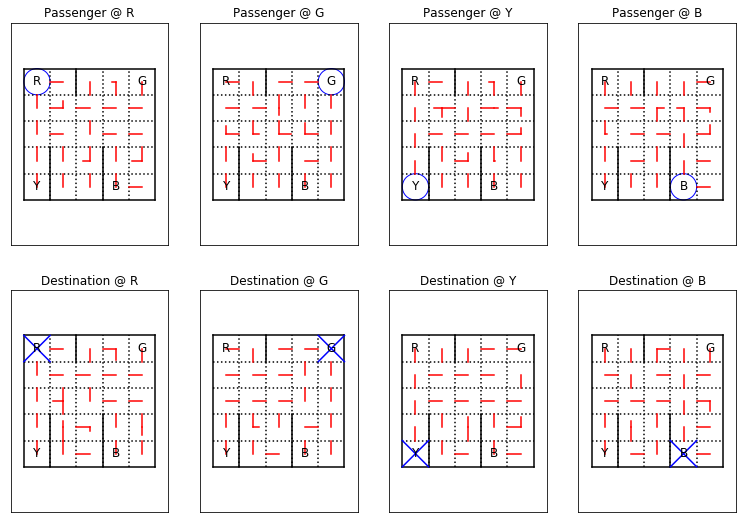

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 800 Total Reward: 9


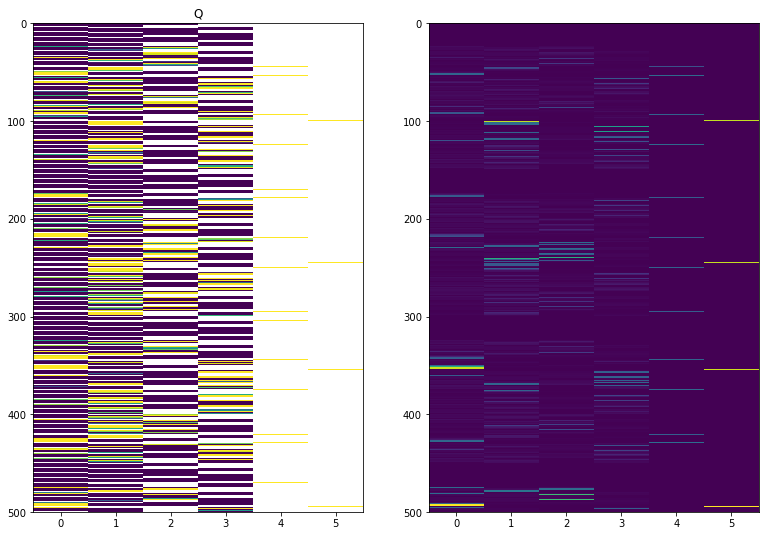

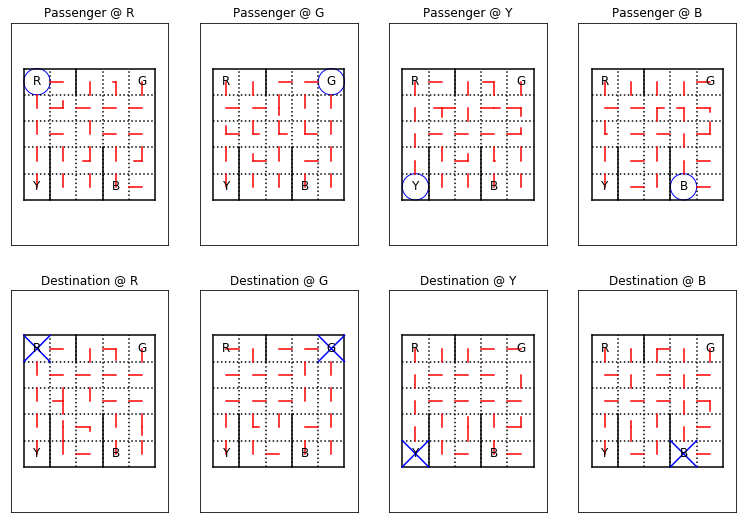

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 900 Total Reward: 7


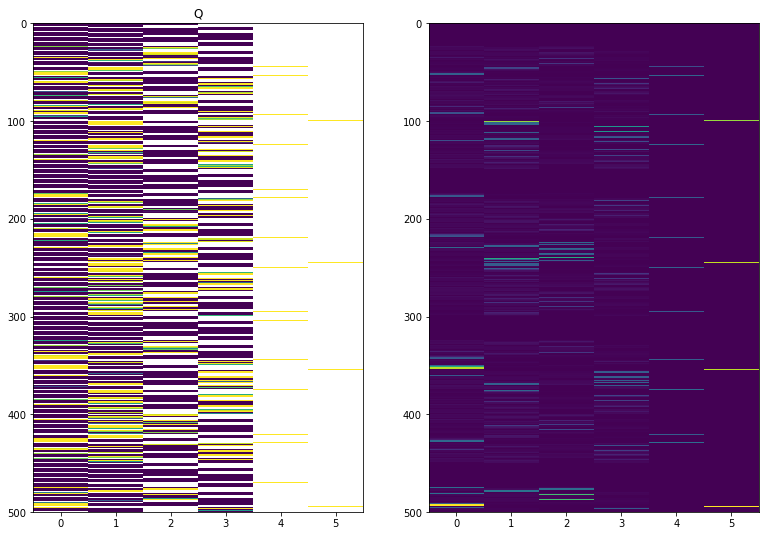

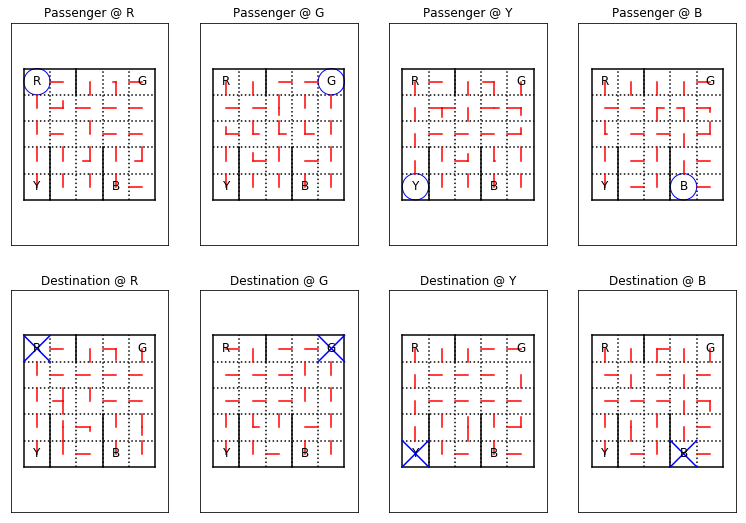

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 1000 Total Reward: 5


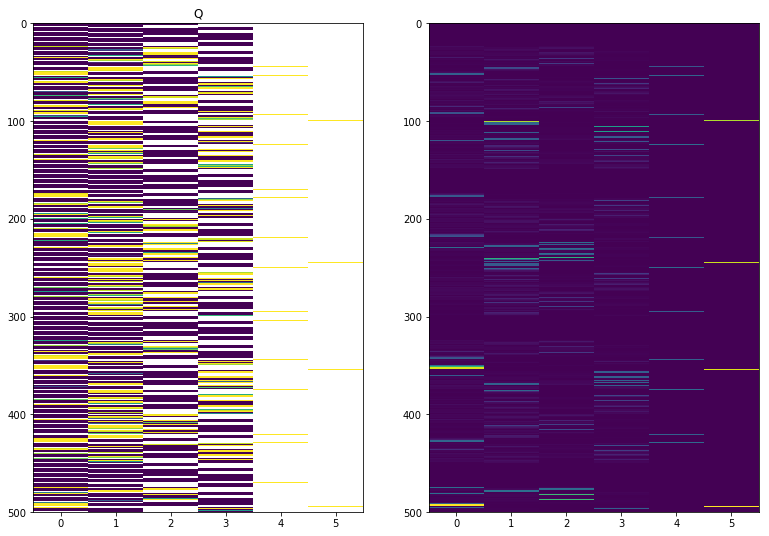

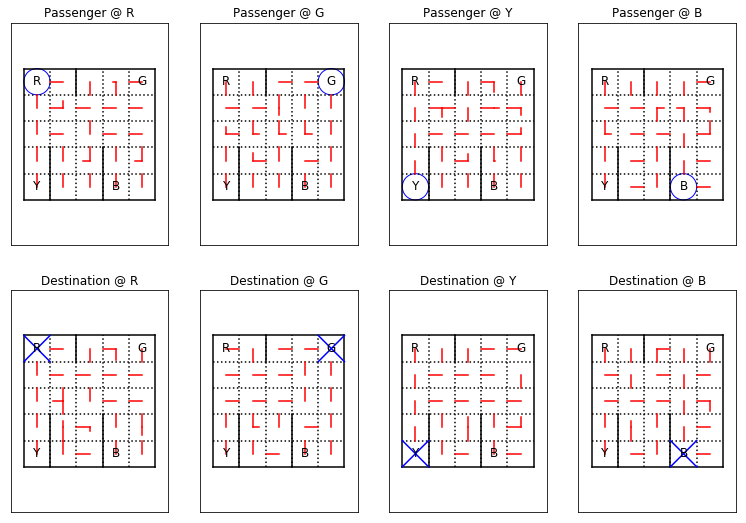

Finished training


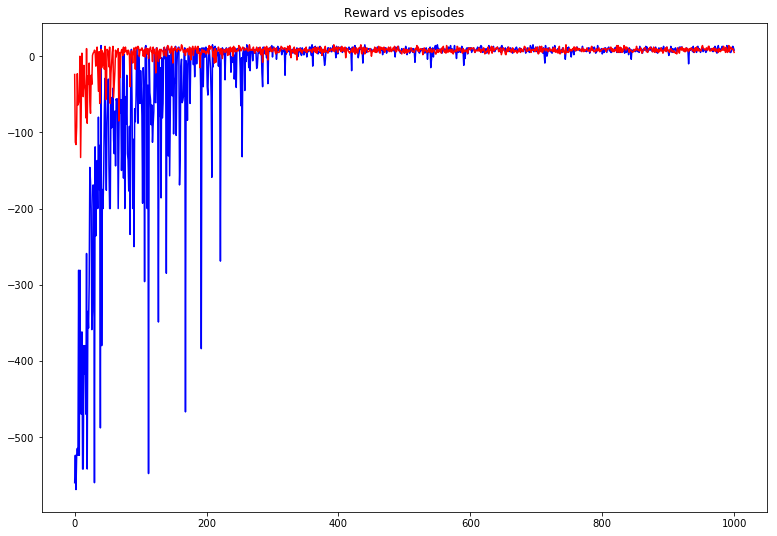

In [ ]:
rewardsOld=rewards
rewards=[]
train()
plt.plot(rewardsOld,'b-')
plt.plot(rewards,'r-')
plt.title("Reward vs episodes")
plt.show()


And we see that the training is much more efficient with this smaller space!